# Air Quality Explained
This notebook uses publicly available data to explain what parameters influence air quality.

## 1. Collecting the data

The data is collected from various sources. For educational purposes, there are presented more difficult methods like webscraping or using a Web API. However, the notebook comes with the data already downloaded. Downloading the data again can cause a lot of traffic and there's a risk of IP ban, so **it is recommended to execute those cells that read offline data.**

### 1A. Webscraping PM2.5 values

In [240]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select
import time
import pandas as pd
import datetime
import calendar

def read_pm25_values(driver, station_name):
    single_station_df = pd.DataFrame(columns =['Date','PM2.5', 'Station'])
    result_container = driver.find_element(By.ID, 'dataResultContainer')
    next_page_exists = True
    while next_page_exists:
        result_rows = result_container.find_element(By.TAG_NAME, 'tbody').find_elements(By.TAG_NAME, 'tr')
        for row in result_rows:
            if row.text.find('-') != -1: # this is not a summary row - continue
                date = row.find_element(By.TAG_NAME, 'th').text
                pm25 = row.find_element(By.TAG_NAME, 'td').text
                row_df = pd.DataFrame({'Date': date, 'PM2.5': pm25, 'Station': station_name}, index=[0])
                single_station_df = pd.concat([single_station_df, row_df])
        pagination = driver.find_element(By.ID, "dataTablePagination").find_elements(By.TAG_NAME, "li")
        last_page_button = pagination[len(pagination)-1].find_element(By.TAG_NAME, 'a')
        if last_page_button.get_attribute('data-page') is not None:
            last_page_button.click()
            time.sleep(4)
        else:
            next_page_exists = False
    return single_station_df

def iterate_months(start_year, start_month, end_year, end_month):
    current_year = start_year
    current_month = start_month
    monthsdf = pd.DataFrame(columns =['Date','PM2.5', 'Station'])

    while (current_year < end_year) or (current_year == end_year and current_month <= end_month):
        start_date = f"{current_year:04d}-{current_month:02d}-01"
        last_day = calendar.monthrange(current_year, current_month)[1]
        end_date = f"{current_year:04d}-{current_month:02d}-{last_day:02d}"
        
        startDate = driver.find_element(By.ID, 'startDate')
        driver.execute_script("arguments[0].removeAttribute('readonly','readonly')", startDate)
        startDate.clear()
        startDate.send_keys(start_date)
        
        endDate = driver.find_element(By.ID, 'endDate')
        driver.execute_script("arguments[0].removeAttribute('readonly','readonly')", endDate)
        endDate.clear()
        endDate.send_keys(end_date)
        
        safeSpace = driver.find_element(By.CLASS_NAME, 'archive-limited-header')
        safeSpace.click() # this is to hide the datepickers
        
        searchBtn = driver.find_element(By.ID, 'searchButton')
        searchBtn.click()
        
        delay = 5 # seconds
        try:
            myElem = WebDriverWait(driver, delay).until(EC.presence_of_element_located((By.ID, 'searchResultTable')))
        except TimeoutException:
            print("Loading took too much time!")
        
        table = driver.find_element(By.ID, 'searchResultTable')
        actions = ActionChains(driver)
        #actions.move_to_element(table).perform()
        time.sleep(1)
        table_body = table.find_element(By.TAG_NAME, 'tbody')
        table_rows = table_body.find_elements(By.TAG_NAME, 'tr')
        read_stations = 0
        for row in table_rows:
            radio = row.find_element(By.TAG_NAME, "input")
            radio.click()
            station_name = row.find_elements(By.TAG_NAME, 'td')[1].text
            add_button = driver.find_element(By.ID, 'addButton')
            add_button.click()
            
            dataType = driver.find_element(By.ID, 'dataTypeSelect')
            dataTypeSelect = Select(dataType)
            dataTypeSelect.select_by_value('aggrResults')
            
            tableButton = driver.find_element(By.ID, 'tableButton')
            tableButton.click()
            
            time.sleep(3)
            
            single_station_df = read_pm25_values(driver, station_name)
            monthsdf = pd.concat([monthsdf, single_station_df])
            read_stations = read_stations + 1
            if read_stations > 1:
                break # for debug, we read only two stations, not to overload the server
            collapseButton = driver.find_element(By.ID, 'collapseButton')
            collapseButton.click()
            time.sleep(1)
            radio.click()   # 'unclick'
        
        # Move to the next month
        if current_month == 12:
            current_month = 1
            current_year += 1
        else:
            current_month += 1
        
        time.sleep(1)
    return monthsdf

ch = Service()
driver = webdriver.Chrome(service = ch)
driver.get('https://powietrze.gios.gov.pl/pjp/archives')

wsdf = pd.DataFrame(columns =['Date','PM2.5', 'Station'])

pollutionSelector = driver.find_element(By.XPATH, "//input[@placeholder='Wybierz  zanieczyszczenie']")
pollutionSelector.click()

pm25opt = driver.find_element(By.XPATH, "//li[text()='pył zawieszony PM2.5']")
pm25opt.click()

measurementSelection = driver.find_element(By.XPATH, "//input[@placeholder='Wybierz tryb pomiaru']")
measurementSelection.click()

measurement_opt = driver.find_element(By.XPATH, "//li[text()='automatyczny']") # for manual stations, there's a need for different handling of aggregates
measurement_opt.click()


monthsdf = iterate_months(2023, 1, 2023, 2)    # just to months for debug purposes
wsdf = pd.concat([wsdf, monthsdf])
wsdf        


,Date,PM2.5,Station
0,2023-01-01,"9,9",DsJelGorOgin
0,2023-01-02,"13,1",DsJelGorOgin
0,2023-01-03,"17,5",DsJelGorOgin
0,2023-01-04,"20,5",DsJelGorOgin
0,2023-01-05,"3,4",DsJelGorOgin
0,2023-01-06,"7,8",DsJelGorOgin
0,2023-01-07,"22,0",DsJelGorOgin
0,2023-01-08,"19,1",DsJelGorOgin
0,2023-01-09,"16,7",DsJelGorOgin
0,2023-01-10,"13,1",DsJelGorOgin


### 1B. Reading offline PM2.5 values

Let's import an Excel spreadsheet containing PM2.5 readouts from monitoring stations owned by Chief Inspectorate for Environmental Protection (https://powietrze.gios.gov.pl/). Then, let's rename one columns to English and let's take a look at our data:

In [94]:
import pandas as pd

pm25_raw = pd.read_excel('2023_PM25_24g.xlsx', header=5)  # the real useful data starts at row 5 which is the header
pm25_raw.rename(columns={'Czas pomiaru': 'Date'}, inplace=True)
pm25_raw.sample(5)

,Date,DsLegPolarna-PM2.5-24g,DsOsieczow21-PM2.5-24g,DsWalbrzWyso-PM2.5-24g,DsWrocNaGrob-PM2.5-24g,DsZgorBohGet-PM2.5-24g,KpBydFieldor-PM2.5-24g,KpGrudSienki-PM2.5-24g,KpToruDziewu-PM2.5-24g,KpWloclGniaz-PM2.5-24g,...,WmOlsPuszkin-PM2.5-24g,WmOstrPilsud-PM2.5-24g,WmPuszczaBor-PM2.5-24g,WpKaliSawick-PM2.5-24g,WpPleszAlMic-PM2.5-24g,WpPoznSzwajc-PM2.5-24g,ZpKoszSpasow-PM2.5-24g,ZpMyslZaBram-PM2.5-24g,ZpSzczAndrze-PM2.5-24g,ZpSzczec1Maj-PM2.5-24g
176,2023-06-26,15.0,8.6,11.3,11.7,12.9,10.5,9.3,11.9,11.6,...,10.30,7.70,8.26,11.4,13.8,16.1,16.7,17.3,24.7,13.6
105,2023-04-16,16.2,9.0,24.7,15.3,17.6,8.9,6.1,8.9,16.7,...,6.92,7.60,14.15,17.6,19.6,15.2,17.1,16.5,7.6,14.5
50,2023-02-20,5.2,4.8,8.2,7.3,8.9,6.2,7.8,5.4,8.0,...,4.31,6.39,6.48,8.0,9.6,7.9,5.1,7.1,5.8,6.5
32,2023-02-02,8.5,6.5,6.8,5.9,10.3,4.2,8.9,3.6,7.3,...,4.30,5.91,4.50,5.6,10.7,4.9,6.5,6.0,10.8,7.6
39,2023-02-09,26.3,29.0,16.0,37.0,23.7,32.3,51.8,44.2,46.8,...,33.94,31.38,28.29,51.1,44.0,39.4,20.3,26.9,13.0,25.9


The date column looks nice. We also have 56 columns representing stations. That's not really suitable for further analysis. We need to 'unpivot' the table so that each row is a single PM2.5 measurement. Also, we can strap the constant suffix from the stations' names - it will be useful for further merge.

In [95]:
pm25_unpivot = pm25_raw.melt(id_vars=['Date'], var_name='Station', value_name='PM2.5')
pm25_unpivot['Station'] = pm25_unpivot['Station'].apply(lambda x: x.removesuffix('-PM2.5-24g')) # requires python >= 3.9
pm25_unpivot.sample(5)

,Date,Station,PM2.5
11764,2023-03-26,PdLomSikorsk,14.9
14917,2023-11-14,SlGodGliniki,3.7
10317,2023-04-08,MzWarWokalna,10.0
2807,2023-09-10,KpToruDziewu,19.6
2532,2023-12-09,KpGrudSienki,35.5


### 2. Enriching with station details
Now the dataframe is ready to be extended with other data. Let's enrich every row with information about the station. GIOŚ offers an Excel file with such a details, where every station has its code. Let's read this spreadsheet:

In [119]:
metadata = pd.read_excel('station_metadata.xlsx')
metadata.sample(5)

,Nr,Kod stacji,Kod międzynarodowy,Nazwa stacji,Stary Kod stacji \n(o ile inny od aktualnego),Data uruchomienia,Data zamknięcia,Typ stacji,Typ obszaru,Rodzaj stacji,Województwo,Miejscowość,Adres,WGS84 φ N,WGS84 λ E
588,589,MzSierpcPiastWSSE,NaN,Sierpc-Piastowska,NaN,1987-02-03,2006-12-31,tło,miejski,w budynku,MAZOWIECKIE,Sierpc,ul. Piastowska 24,52.853175,19.666716
99,100,DsSnie04,PL0058A,Śnieżne Kotły,NaN,1996-07-01,2010-12-31,tło,pozamiejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,0,Śnieżne Kotły,50.778373,15.557425
502,503,MpSuchaWIOSMick1502,NaN,Sucha Beskidzka Mickiewicza LOK,NaN,2003-01-01,2003-12-31,tło,miejski,w budynku,MAŁOPOLSKIE,Sucha Beskidzka,ul. Miskiewicza 9,49.738333,19.592778
98,99,DsSlone,NaN,Słone,NaN,1980-01-01,2003-12-31,przemysłowa,pozamiejski,w budynku,DOLNOŚLĄSKIE,Słone,NaN,51.661053,16.022652
92,93,DsPolKasztan,PL0057A,"Polkowice, ul. Kasztanowa",DsPolkKasz,2004-05-01,NaT,tło,miejski,wolnostojący pobornik pyłu,DOLNOŚLĄSKIE,Polkowice,ul. Kasztanowa 29,51.502370,16.075051


The metadata dataframe contains both useful columns and those which can be ignored. Let's clean this up. Also, let's take a look at latitude/longitude - are those values always correct?

In [120]:
metadata.drop(columns=['Nr',
                      'Kod międzynarodowy',
                      'Nazwa stacji', 
                      'Stary Kod stacji \n(o ile inny od aktualnego)',
                      'Data uruchomienia',
                      'Data zamknięcia'], inplace=True)
metadata.rename(columns={'Kod stacji': 'Station',
                         'Typ stacji': 'Station type',
                         'Typ obszaru': 'Area type',
                         'Rodzaj stacji': 'Station kind',
                         'Województwo': 'Province',
                         'Miejscowość': 'Town',
                         'Adres': 'Address',
                         'WGS84 φ N': 'Latitude',
                         'WGS84 λ E': 'Longitude'}, inplace=True)
metadata['Latitude'].describe()

count    1095.000000
mean      -21.259381
std       267.145159
min      -999.000000
25%        50.295973
50%        51.244431
75%        52.651561
max        54.793639
Name: Latitude, dtype: float64

The minimal value looks terribly wrong. Let's remove it from the metadata set.

In [121]:
metadata.drop(metadata[metadata.Latitude == -999].index, inplace=True)
metadata.sample(5)

,Station,Station type,Area type,Station kind,Province,Town,Address,Latitude,Longitude
112,DsSzczAzalMob,tło,miejski,mobilna,DOLNOŚLĄSKIE,Szczawno-Zdrój,ul. Klonowa,50.806472,16.253264
566,MzPlockPKN3,przemysłowa,miejski,kontenerowa stacjonarna,MAZOWIECKIE,Chełpowo,ul. Długa,52.567500,19.687500
807,PmGdyWendy10,tło,miejski,kontenerowa stacjonarna,POMORSKIE,Gdynia,ul. Wendy,54.525274,18.536382
103,DsSpal06,tło,pozamiejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Spalona,NaN,50.276570,16.538299
174,KpBydgZachemWojska,tło,miejski,w budynku,KUJAWSKO-POMORSKIE,Bydgoszcz,ul. Wojska Polskiego 46,53.102222,18.059444


Now we're ready to merge our PM2.5 df with station data. We use inner matching strategy - if there is no matching station we want to drop the row.

In [122]:
pm25_stations = pd.merge(pm25_unpivot, metadata, on='Station', how='inner')
pm25_stations.sample(5)

,Date,Station,PM2.5,Station type,Area type,Station kind,Province,Town,Address,Latitude,Longitude
2269,2023-03-21,KpGrudSienki,15.2,tło,miejski,wolnostojący pobornik pyłu,KUJAWSKO-POMORSKIE,Grudziądz,ul. Sienkiewicza 27,53.491831,18.752503
3464,2023-06-29,KpZielBoryTu,10.0,tło,pozamiejski,kontenerowa stacjonarna,KUJAWSKO-POMORSKIE,Zielonka,Bory Tucholskie,53.662117,17.934017
14882,2023-10-10,SlGodGliniki,18.7,tło,pozamiejski,kontenerowa stacjonarna,ŚLĄSKIE,Godów,ul. Gliniki,49.921875,18.471278
12156,2023-04-22,PkRzeszRejta,20.3,tło,miejski,kontenerowa stacjonarna,PODKARPACKIE,Rzeszów,Rejtana,50.024242,22.010575
9644,2023-06-04,MzRadHallera,9.2,tło,miejski,wolnostojący pobornik pyłu,MAZOWIECKIE,Radom,ul. Hallera,51.415324,21.171285


### 3A. Fetching weather data

Analysis revealed that most weather APIs are either expensive or have limited access to historical data. Open Meteo seems to be the only reasonable choice. In this step, I'll download the weather historical weather data between 01.01.2023 and 31.12.2023 (this is the period we have our PM2.5 values from). There's one request per unique station in the data frame. Then, the results (JSONs) are stored in folder - so that any further processing won't require redownloading them again.

In [71]:
import os
import requests
import json

stations = pm25_stations[['Station', 'Latitude', 'Longitude']].drop_duplicates()
output_dir = 'weather'
os.makedirs(output_dir, exist_ok=True)

def fetch_weather_data(station, latitude, longitude):
    # start and end date and required variable are part of the URL
    url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date=2023-01-01&end_date=2023-12-31&daily=weather_code,temperature_2m_mean,daylight_duration,sunshine_duration,precipitation_sum,wind_speed_10m_max&timezone=Europe%2FBerlin"
    response = requests.get(url)
    if response.status_code == 200:
        file_path = os.path.join(output_dir, f"{station}.json")
        with open(file_path, 'w') as file:
            json.dump(response.json(), file)
        print(f"Data for station {station} saved successfully.")
    else:
        print(f"Failed to fetch data for station {station}.")

for _, row in stations.iterrows():
    fetch_weather_data(row['Station'], row['Latitude'], row['Longitude'])

Data for station DsLegPolarna saved successfully.
Data for station DsOsieczow21 saved successfully.
Data for station DsWalbrzWyso saved successfully.
Data for station DsWrocNaGrob saved successfully.
Data for station DsZgorBohGet saved successfully.
Data for station KpBydFieldor saved successfully.
Data for station KpGrudSienki saved successfully.
Data for station KpToruDziewu saved successfully.
Data for station KpWloclGniaz saved successfully.
Data for station KpZielBoryTu saved successfully.
Data for station LbBiaPodOrze saved successfully.
Data for station LbChelmPolan saved successfully.
Data for station LbLubSliwins saved successfully.
Data for station LdLodzCzerni saved successfully.
Data for station LdLodzLegion saved successfully.
Data for station LdPioTrKraPr saved successfully.
Data for station LuGorzPilsud saved successfully.
Data for station LuNowaSolKos saved successfully.
Data for station LuZielKrotka saved successfully.
Data for station MpBochKonfed saved successfully.


### 3B. Enriching with weather data

Regardless if JSONs were downloaded using the code block above or supplied JSONs are used, now it's time to read the files and make a data frame out of them.

In [123]:
weather_data = [] # array containing parsed jsons
stations = pm25_stations[['Station', 'Latitude', 'Longitude']].drop_duplicates() # unique list of stations - in case previous block was not executed

def process_json_file(station, file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        elevation = data.get('elevation', None) # elevation is taken from weather data, but it is obviously 'static'
        daily_data = data.get('daily', {})
        time = daily_data.get('time', [])
        weather_code = daily_data.get('weather_code', [])
        temperature_2m_mean = daily_data.get('temperature_2m_mean', [])
        daylight_duration = daily_data.get('daylight_duration', [])
        sunshine_duration = daily_data.get('sunshine_duration', [])
        precipitation_sum = daily_data.get('precipitation_sum', [])
        wind_speed_10m_max = daily_data.get('wind_speed_10m_max', [])
        
        for i, date in enumerate(time):
            weather_data.append({
                'Station': station,
                'Date': date,
                'weather_code': weather_code[i] if i < len(weather_code) else None,
                'temperature_2m_mean': temperature_2m_mean[i] if i < len(temperature_2m_mean) else None,
                'daylight_duration': daylight_duration[i] if i < len(daylight_duration) else None,
                'sunshine_duration': sunshine_duration[i] if i < len(sunshine_duration) else None,
                'precipitation_sum': precipitation_sum[i] if i < len(precipitation_sum) else None,
                'wind_speed_10m_max': wind_speed_10m_max[i] if i < len(wind_speed_10m_max) else None,
                'elevation': elevation
            })
            
for station in stations['Station']:
    json_file_path = os.path.join('weather', f"{station}.json") # I assume only correctly named jsons (as Stations) are in the directory
    if os.path.exists(json_file_path):
        process_json_file(station, json_file_path)
        
weather_df = pd.DataFrame(weather_data)
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
weather_df.sample(5)

,Station,Date,weather_code,temperature_2m_mean,daylight_duration,sunshine_duration,precipitation_sum,wind_speed_10m_max,elevation
825,DsWalbrzWyso,2023-04-06,3,0.7,47657.86,42058.92,0.0,14.1,441.0
658,DsOsieczow21,2023-10-21,51,12.9,37332.62,32789.57,0.6,20.9,179.0
4744,LbLubSliwins,2023-12-31,3,2.8,28589.55,21419.88,0.0,16.9,210.0
10915,OpKluczMicki,2023-11-27,3,-2.6,30299.58,23309.43,0.0,11.7,182.0
5806,LdPioTrKraPr,2023-11-28,73,-3.3,29941.79,0.00,2.2,21.6,197.0


The data looks promising and is quite obvious to read with exception of one parameter - **weather_code**. This is a coded variable in WMO CODE: https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM . Let's add a new column with human readable values. Usually we do something separate (human readable values coded to numbers to do regression), but for now we need nice labels for visualisation.

In [124]:
wmo_codes = {
    0: "Clear sky",
    1: "Mainly clear",
    2: "Partly cloudy",
    3: "Overcast",
    51: "Drizzle: Light",
    53: "Drizzle: Moderate",
    55: "Drizzle: Dense",
    61: "Rain: Slight",
    63: "Rain: Moderate",
    65: "Rain: Heavy",
    71: "Snowfall: Slight",
    73: "Snowfall: Moderate",
    75: "Snowfall: Heavy"
}
weather_df['weather_desc'] = weather_df['weather_code'].map(wmo_codes)
weather_df.sample(5)

,Station,Date,weather_code,temperature_2m_mean,daylight_duration,sunshine_duration,precipitation_sum,wind_speed_10m_max,elevation,weather_desc
16953,WmOlsPuszkin,2023-06-13,3,15.2,61333.81,14407.39,0.0,22.4,127.0,Overcast
7890,MpNoSaczNadb,2023-08-14,0,23.6,52283.80,47565.84,0.0,8.6,295.0,Clear sky
10115,MzWarTolstoj,2023-09-18,1,20.6,45035.83,39759.98,0.0,17.1,99.0,Mainly clear
12972,SkBuskRokosz,2023-07-17,63,22.9,57413.65,28196.61,10.0,15.0,220.0,Rain: Moderate
15469,SlTarnoLitew,2023-05-20,51,14.8,56466.39,51033.84,0.3,21.6,324.0,Drizzle: Light


Finally we are ready to merge our weather data with main data frame:

In [125]:
pm25_st_wt = pd.merge(pm25_stations, weather_df, how='left', left_on=['Station', 'Date'], right_on=['Station', 'Date'])
pm25_st_wt.sample(5)

,Date,Station,PM2.5,Station type,Area type,Station kind,Province,Town,Address,Latitude,Longitude,weather_code,temperature_2m_mean,daylight_duration,sunshine_duration,precipitation_sum,wind_speed_10m_max,elevation,weather_desc
850,2023-05-01,DsWalbrzWyso,10.8,tło,miejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Wałbrzych,ul. Wysockiego 11,50.768729,16.269677,3,10.5,53132.88,47137.97,0.0,18.2,441.0,Overcast
738,2023-01-09,DsWalbrzWyso,21.5,tło,miejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Wałbrzych,ul. Wysockiego 11,50.768729,16.269677,53,3.5,29655.99,3600.00,1.6,27.2,441.0,Drizzle: Moderate
11868,2023-07-08,PdLomSikorsk,7.1,tło,miejski,kontenerowa stacjonarna,PODLASKIE,Łomża,ul. Sikorskiego 48/94,53.181394,22.054381,2,19.7,60172.47,46595.27,0.0,15.0,104.0,Partly cloudy
18786,2023-06-21,ZpKoszSpasow,20.3,tło,miejski,wolnostojący pobornik pyłu,ZACHODNIOPOMORSKIE,Koszalin,ul. Spasowskiego 2f,54.207151,16.193236,65,21.3,61902.22,56178.50,10.4,22.9,48.0,Rain: Heavy
19541,2023-07-16,ZpSzczAndrze,9.6,tło,miejski,kontenerowa stacjonarna,ZACHODNIOPOMORSKIE,Szczecin,ul. Andrzejewskiego 23,53.380975,14.663347,53,23.8,59309.51,41906.77,1.3,22.1,14.0,Drizzle: Moderate


## 2. Data quality check
To some extent we already did some quality improvements (like dropping stations with incorrect coordinates), but now it's time to take a closer look at the data. First, let's see with we have some missing values:

In [126]:
import numpy as np

for col in pm25_st_wt.columns:
  pct_missing = np.mean(pm25_st_wt[col].isnull())
  print(col, '\t', pct_missing * 100, '%')

Date 	 0.0 %
Station 	 0.0 %
PM2.5 	 4.657534246575342 %
Station type 	 0.0 %
Area type 	 0.0 %
Station kind 	 0.0 %
Province 	 0.0 %
Town 	 0.0 %
Address 	 1.8181818181818181 %
Latitude 	 0.0 %
Longitude 	 0.0 %
weather_code 	 0.0 %
temperature_2m_mean 	 0.0 %
daylight_duration 	 0.0 %
sunshine_duration 	 0.0 %
precipitation_sum 	 0.0 %
wind_speed_10m_max 	 0.0 %
elevation 	 0.0 %
weather_desc 	 0.0 %


Less than 5% of measurements are missing. Let's drop them. Also, let's confirm there are no duplicates as well.

In [127]:
pm25_st_wt_cl = pm25_st_wt.dropna()
any(pm25_st_wt_cl.duplicated())

False

As noted before, some of the columns are categorical variables. We need to map them to dummies to perform calculations on them. Not all categorical variables will be mapped to dummies - only those potentially useful.

In [134]:
dummy_df = pd.get_dummies(pm25_st_wt_cl['Area type'], dtype=int)
pm25_dum = pd.concat([pm25_st_wt_cl, dummy_df ], axis=1)
dummy_df = pd.get_dummies(pm25_dum['Province'], dtype=int)
pm25_dum = pd.concat([pm25_dum, dummy_df ], axis=1)
dummy_df = pd.get_dummies(pm25_dum['weather_desc'], dtype=int)
pm25_dum = pd.concat([pm25_dum, dummy_df ], axis=1)
pm25_dum = pm25_dum.drop(['weather_desc', 'weather_code', 'Address', 'Town', 'Province', 'Station kind', 'Area type', 'Station type', 'Station'], axis=1)
pm25_dum.sample(5)

,Date,PM2.5,Latitude,Longitude,temperature_2m_mean,daylight_duration,sunshine_duration,precipitation_sum,wind_speed_10m_max,elevation,...,Drizzle: Moderate,Mainly clear,Overcast,Partly cloudy,Rain: Heavy,Rain: Moderate,Rain: Slight,Snowfall: Heavy,Snowfall: Moderate,Snowfall: Slight
3808,2023-06-08,9.70,52.029194,23.149389,18.9,59738.08,54000.00,0.2,15.3,146.0,...,0,0,0,0,0,0,0,0,0,0
17663,2023-05-24,17.91,54.124819,22.038056,19.1,59205.24,54000.00,0.0,12.1,154.0,...,0,0,1,0,0,0,0,0,0,0
12033,2023-12-20,13.10,53.181394,22.054381,4.8,27110.14,0.00,7.5,28.7,104.0,...,0,0,0,0,0,0,0,0,0,0
14237,2023-01-03,13.50,50.279481,18.655736,6.5,29361.07,22263.82,0.0,20.4,240.0,...,0,0,1,0,0,0,0,0,0,0
7493,2023-07-13,7.50,50.010575,19.949189,20.1,57660.09,23731.98,14.8,16.3,229.0,...,0,0,0,0,0,1,0,0,0,0


## 4. Visual analysis

<Axes: >

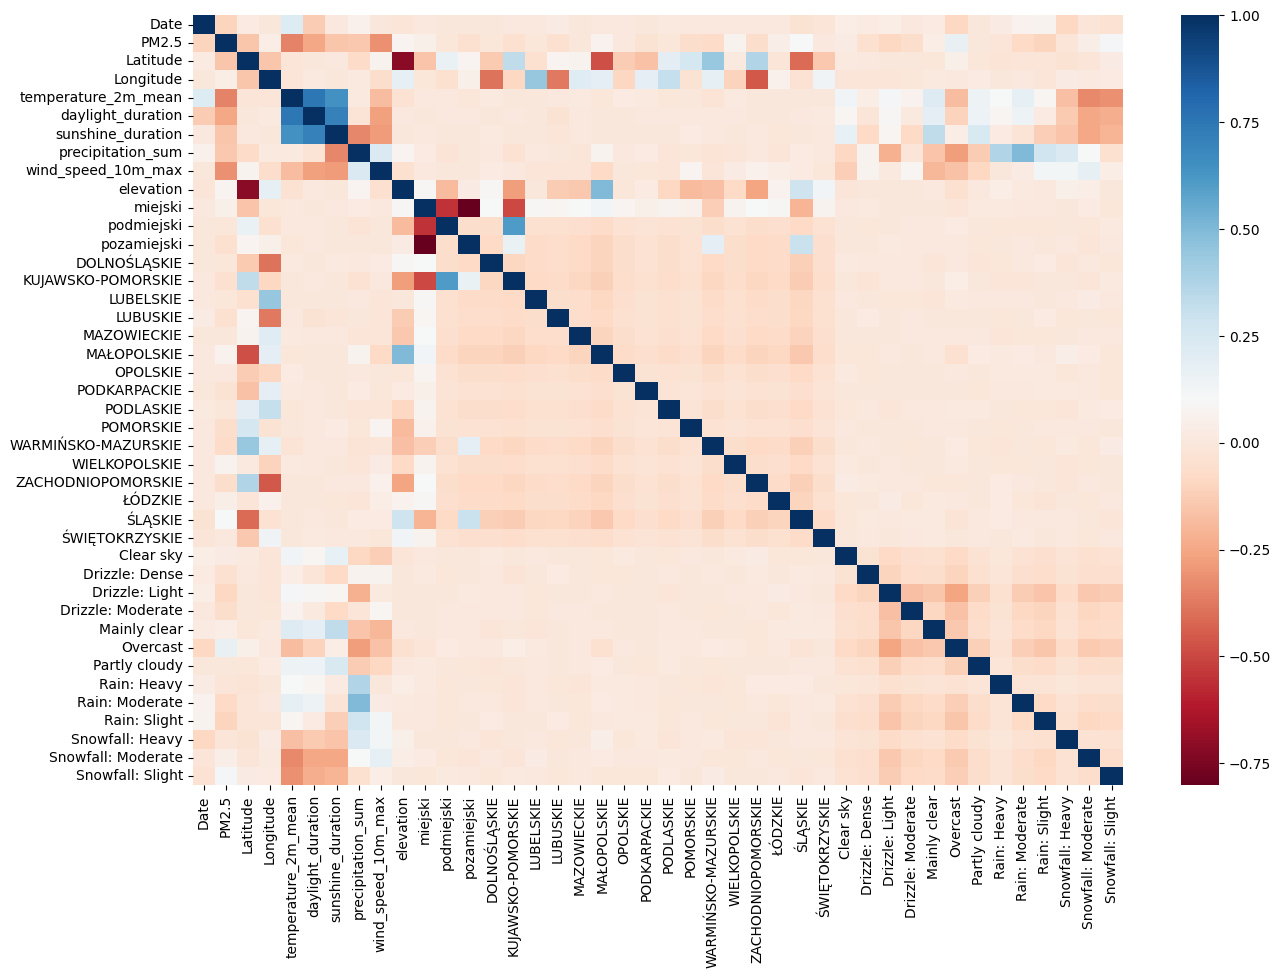

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (15, 10))
sns.heatmap(pm25_dum.corr(), annot = False, cmap="RdBu")

/var/folders/7b/yfxzgtr11sg43l79k4r2dwgc0000gn/T/ipykernel_30414/3235730662.py:3: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



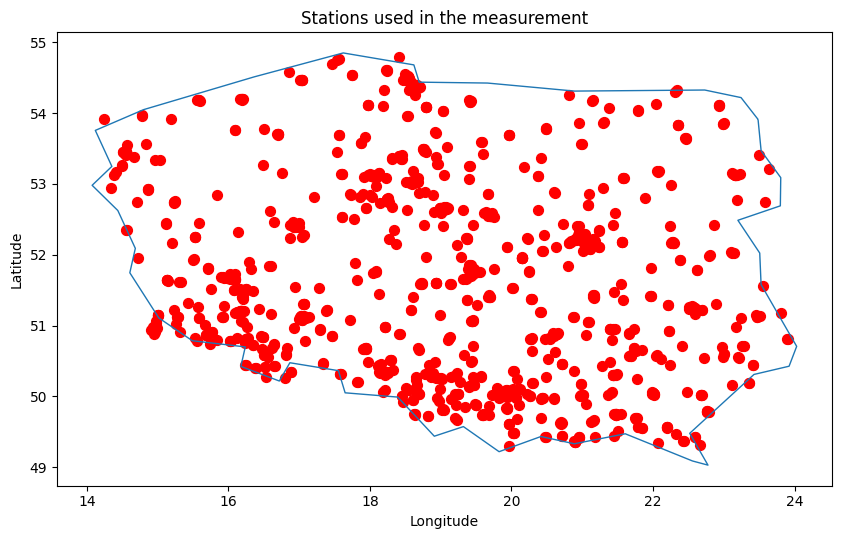

In [255]:
import geopandas as gpd

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
poland = world[world.name == 'Poland']

gdf = gpd.GeoDataFrame(metadata, geometry=gpd.points_from_xy(metadata.Longitude, metadata.Latitude))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
poland.boundary.plot(ax=ax, linewidth=1)
gdf.plot(ax=ax, color='red', markersize=50)

plt.title('Stations used in the measurement')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Text(0, 0.5, 'PM2.5 Concentration')

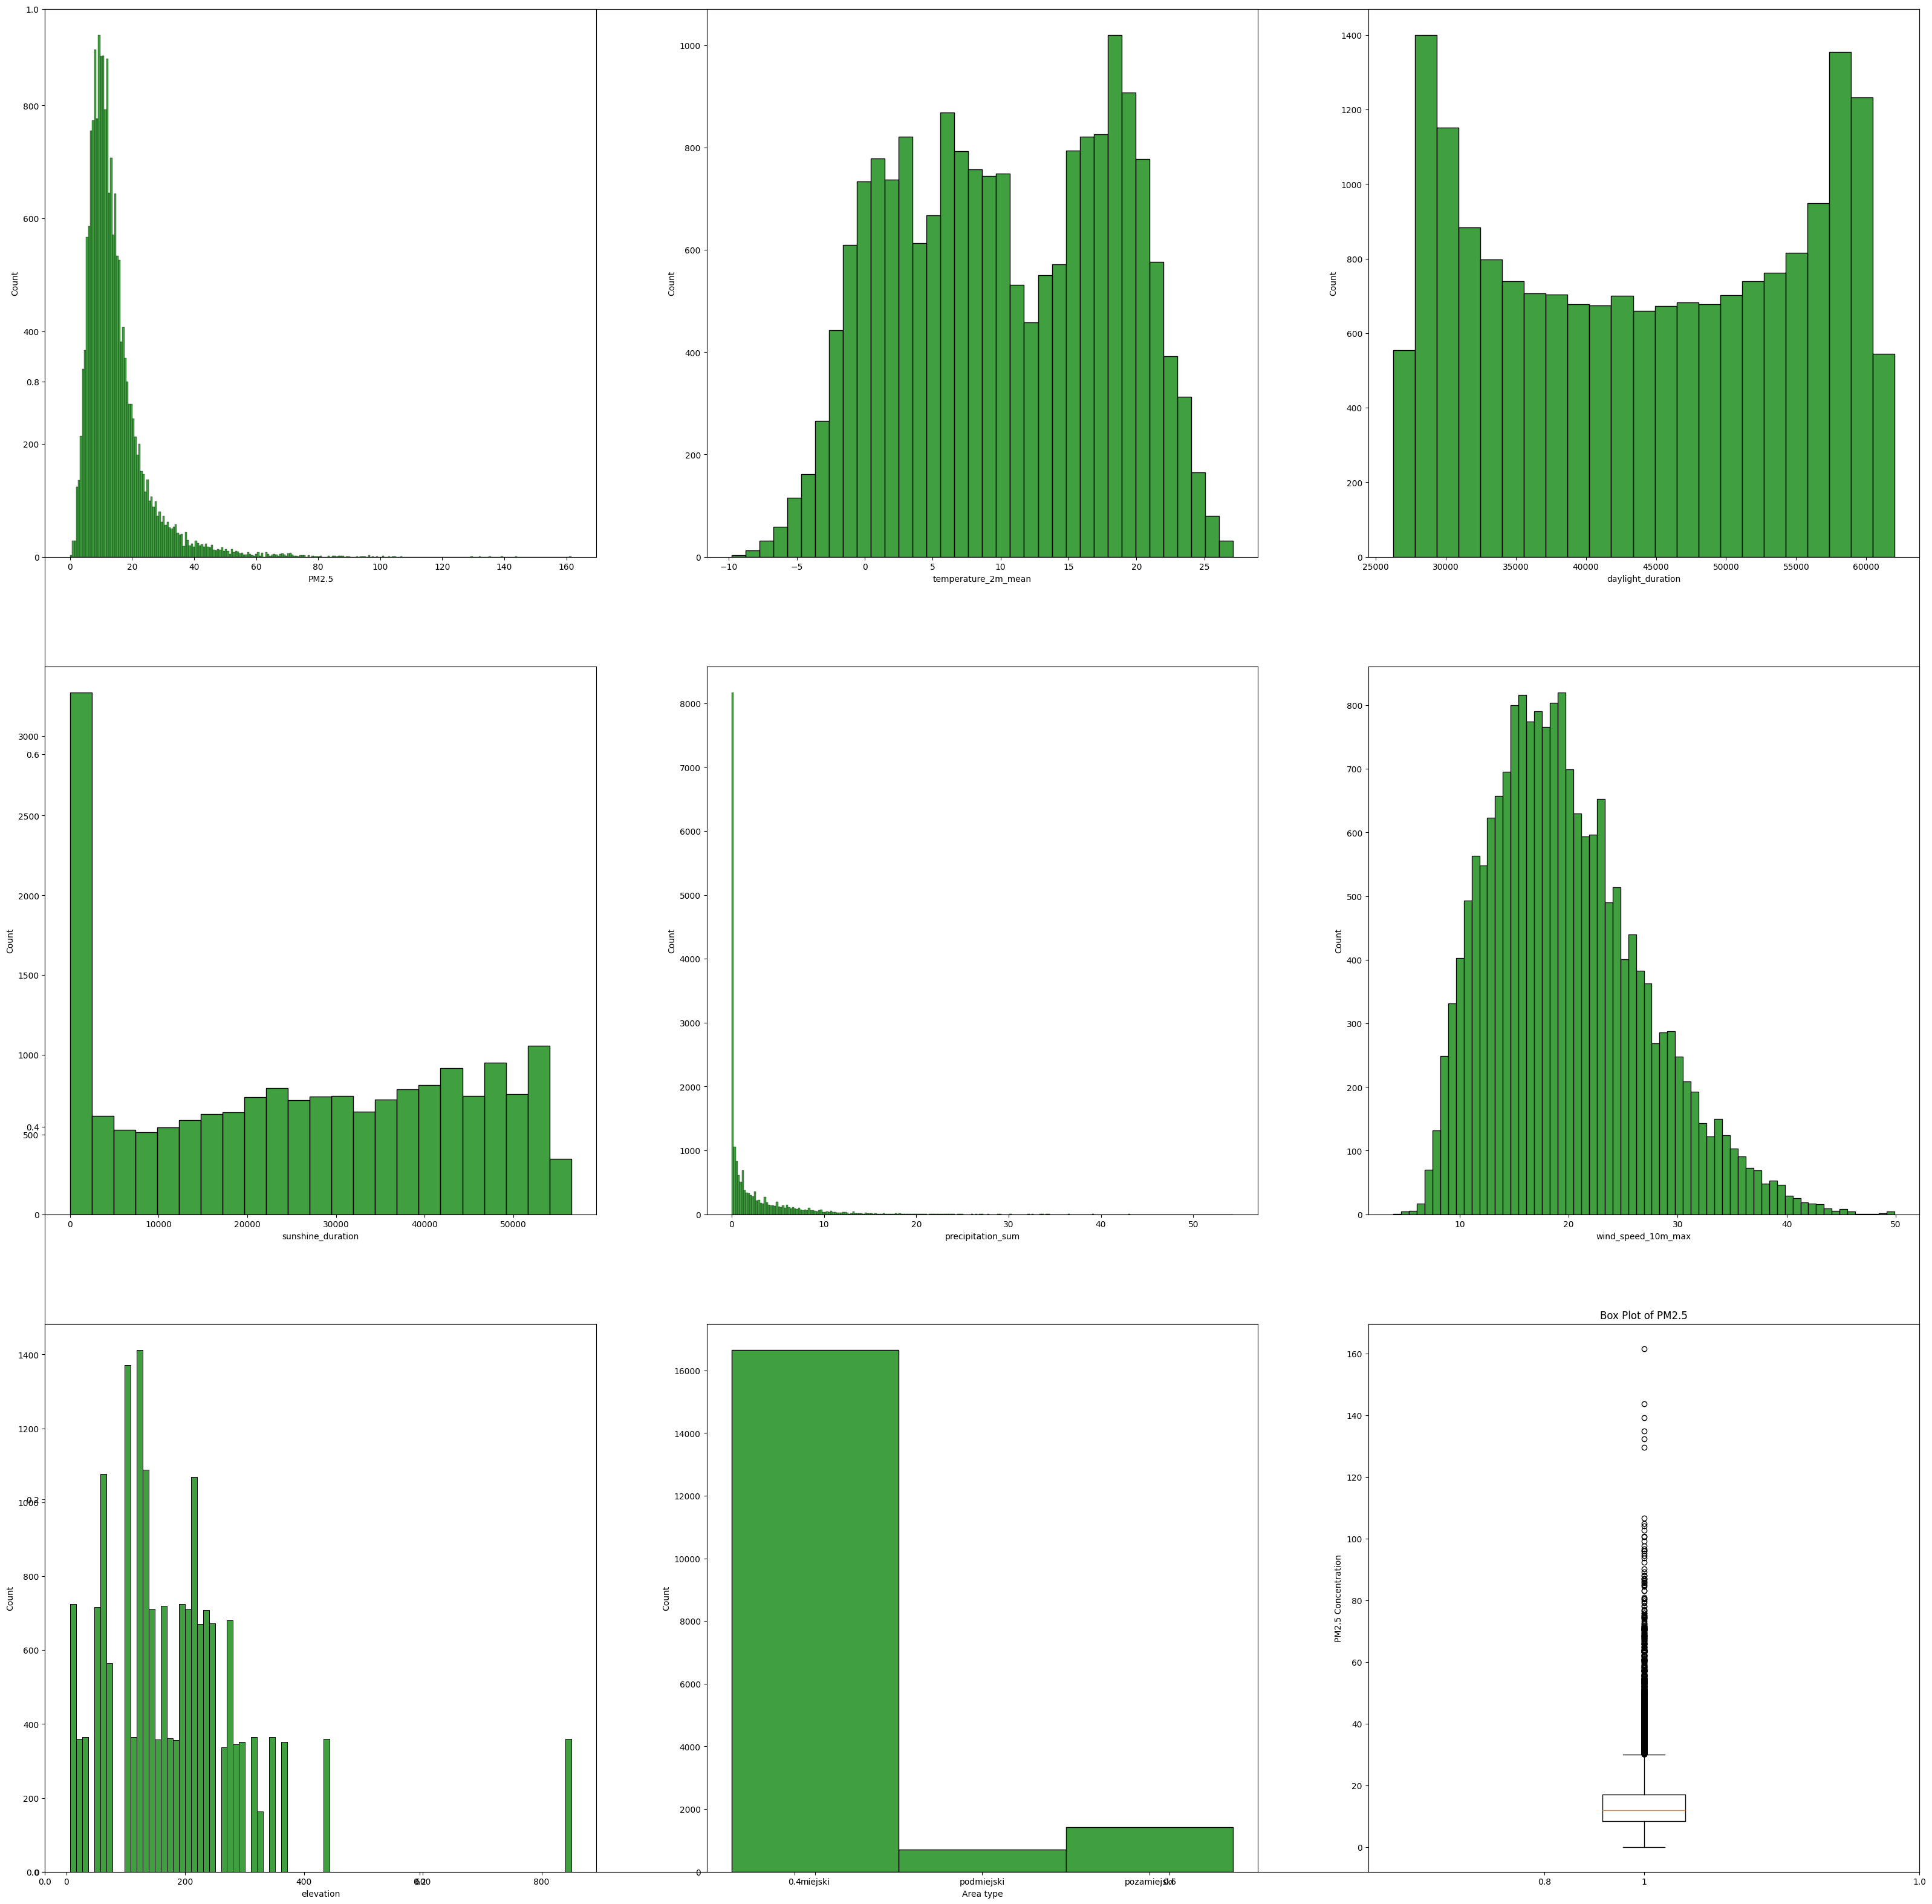

In [269]:
plt.figure(figsize=(40, 40))
plt.subplot()

for i, col in enumerate(['PM2.5', 'temperature_2m_mean', 'daylight_duration', 'sunshine_duration', 'precipitation_sum', 'wind_speed_10m_max', 'elevation', 'Area type']):
    plt.subplot(3, 3, i+1)
    sns.histplot(pm25_st_wt_cl[col], color='green', kde=False)
    
plt.subplot(3, 3, 9)
plt.boxplot(pm25_st_wt_cl['PM2.5'])
plt.title('Box Plot of PM2.5')
plt.ylabel('PM2.5 Concentration')

Text(0, 0.5, 'PM2.5 Concentration')

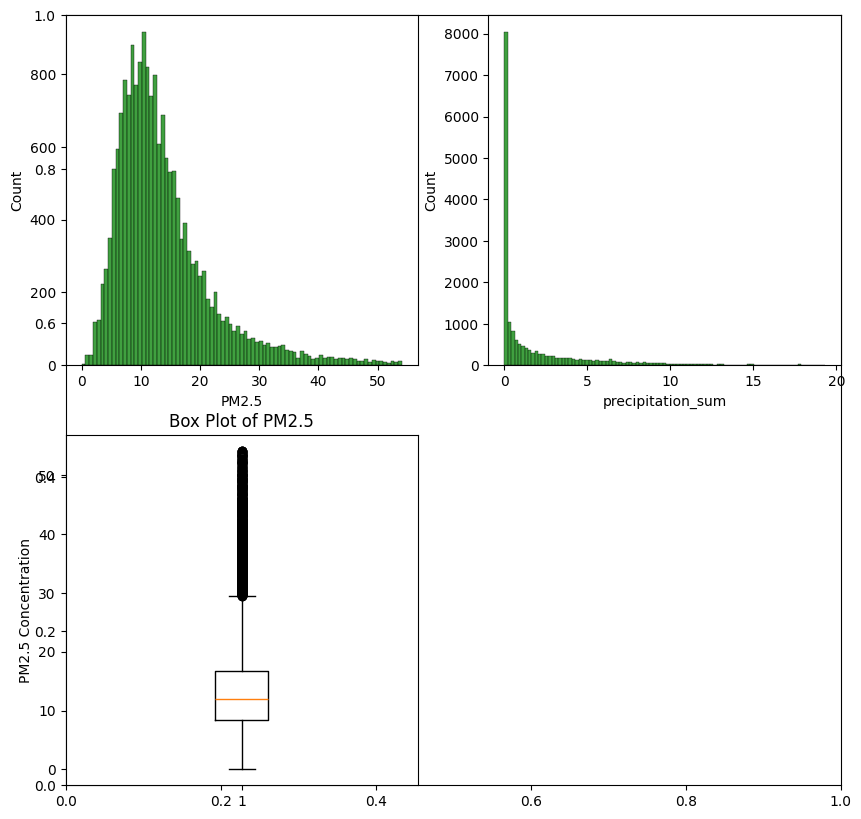

In [271]:
# outliers removal

upper_bound = pm25_dum['PM2.5'].quantile(0.99)
pm25_dum_out = pm25_dum[(pm25_dum['PM2.5'] <= upper_bound)]
upper_bound = pm25_dum_out['precipitation_sum'].quantile(0.99)
pm25_dum_out = pm25_dum_out[(pm25_dum_out['precipitation_sum'] <= upper_bound)]

plt.figure(figsize=(10, 10))
plt.subplot()

for i, col in enumerate(['PM2.5', 'precipitation_sum']):
    plt.subplot(2, 2, i+1)
    sns.histplot(pm25_dum_out[col], color='green', kde=False)
    
plt.subplot(2, 2, 3)
plt.boxplot(pm25_dum_out['PM2.5'])
plt.title('Box Plot of PM2.5')
plt.ylabel('PM2.5 Concentration')

# The following code section uses Dash
# Not every visualizer shows it correctly

In [140]:
from dash import html, dash, dcc, Output, Input
import plotly.express as px

app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    html.H1("PM2.5 visualisation"),
    dcc.Graph(
        id='pm25-vs-temp',
        figure=px.scatter(pm25_st_wt_cl, x='temperature_2m_mean', y='PM2.5', title='Pollution vs. Temperature')
    ),
    dcc.Graph(
        id='pm25-vs-wind',
        figure=px.scatter(pm25_st_wt_cl, x='wind_speed_10m_max', y='PM2.5', title='Pollution vs. Wind')
    ),
    dcc.Dropdown(
        id='month-filter',
        options=[{'label': month, 'value': month} for month in pm25_st_wt_cl['Date'].dt.month.unique()],
        placeholder="Select a month",
        multi=True
    ),
    dcc.Dropdown(
        id='province-filter',
        options=[{'label': province, 'value': province} for province in pm25_st_wt_cl['Province'].unique()],
        placeholder="Select a province",
        multi=True
    ),
    dcc.Dropdown(
        id='weather-filter',
        options=[{'label': weatherc, 'value': weatherc} for weatherc in pm25_st_wt_cl['weather_desc'].unique()],
        placeholder="Select a weather condition",
        multi=True
    ),
    dcc.Graph(id='daily-avg-pm25'),
    dcc.Graph(id='province-avg-pm25')
])

# Callback to update the daily average PM2.5 graph
@app.callback(
    Output('daily-avg-pm25', 'figure'),
    [Input('month-filter', 'value'),
     Input('province-filter', 'value'),
     Input('weather-filter', 'value')]
)
def update_daily_avg_pm25(month_filter, province_filter, weather_filter):
    filtered_df = pm25_st_wt_cl.copy()
    if month_filter:
        filtered_df = filtered_df[filtered_df['Date'].dt.month.isin(month_filter)]
    if province_filter:
        filtered_df = filtered_df[filtered_df['Province'].isin(province_filter)]
    if weather_filter:
        filtered_df = filtered_df[filtered_df['weather_desc'].isin(weather_filter)]
    
    daily_avg = filtered_df.groupby('Date')['PM2.5'].mean().reset_index()
    fig = px.line(daily_avg, x='Date', y='PM2.5', title='Daily Average of PM2.5')
    return fig

# Callback to update the province average PM2.5 graph
@app.callback(
    Output('province-avg-pm25', 'figure'),
    [Input('month-filter', 'value'),
     Input('weather-filter', 'value')]
)
def update_province_avg_pm25(month_filter, weather_filter):
    filtered_df = pm25_st_wt_cl.copy()
    if month_filter:
        filtered_df = filtered_df[filtered_df['Date'].dt.month.isin(month_filter)]
    if weather_filter:
        filtered_df = filtered_df[filtered_df['weather_desc'].isin(weather_filter)]
    
    province_avg = filtered_df.groupby(['Date', 'Province'])['PM2.5'].mean().reset_index()
    fig = px.line(province_avg, x='Date', y='PM2.5', color='Province', title='Daily Average of PM2.5 by Province')
    return fig

# Run the app in Jupyter
app.run_server(mode='inline')

### Conclusions from basic data analysis

* High pollution happens when temperature is low
* High pollution happens when there's no wind
* Spikes of high pollution happens at the same time in the country, regardless of province
* Provinces located at sea have the lowest pollution
    * If we filter for months with high pollution (e.g. January and February), the lowest values are in Pomeranian and West Pomeranian
    * Proximity to the sea causes mild temperatures
    * Those are also the most windy areas in Poland

## 5. Linear regression
Our target variable, PM2.5 is continuous (as depicted on the charts above). Thus, **this is a regression**, not classification problem.

In [277]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = pm25_dum.drop(columns=['PM2.5', 'Date', 'Latitude', 'Longitude'])
y = pm25_dum['PM2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.3079143037577531

Let's interpret the R<sup>2</sup> value:
* R<sup>2</sup> < 0 - model is worse at predicting than average of the target variable
* 0 ≤ R<sup>2</sup> < 0.3 - weak to none influence of the variables
* 0 ≤ R<sup>2</sup> < 0.3 - reasonable influence
* R<sup>2</sup> ≥ 0.7 - strong influence of variables on target

The model is not good, but it's not terrible either.

I also tried improving it by scaling, but it didn't help.

The description of the project explicitly allows both regression and classification problems. At the same time, the task requires to assess my model with accuracy or F1 score - but those are only for classification. Thus, I use metrics typical to regression to comment on my model.

In [278]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, y_train_scaled)
model_scaled.score(X_test_scaled, y_test_scaled)

0.3078344297498439

In [281]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

mae, mse

(5.81480657406703, 70.82099545641607)

MAE value = 5.8 means that on average predictions of PM2.5 are off by 5.8 by this model. MSE equal to 70 denotes that the outliers have larger impact on errors (the value is squared, so it's more difficult to interpret it).

In [282]:
coefficients = model.coef_
variables = X.columns
coefficients_df = pd.DataFrame({'Variable': variables, 'Coefficient': coefficients})
coefficients_df

,Variable,Coefficient
0,temperature_2m_mean,-0.531217
1,daylight_duration,-0.000099
2,sunshine_duration,0.000009
3,precipitation_sum,-0.287232
4,wind_speed_10m_max,-0.523904
5,elevation,-0.005500
6,miejski,0.372566
7,podmiejski,0.934078
8,pozamiejski,-1.306644
9,DOLNOŚLĄSKIE,0.277907


A couple of outtakes from coefficients:
* a raise in temperature by 1°C decreases PM2.5 value by 0.53
* a raise in wind speed by 1 km/h decreases PM2.5 value by 0.52
* location in city increases the pollution, while countryside decreases the pollution
* the most polluted are suburbs
* sunshine duration has no impact on pollution

In [283]:
import pickle
model_file = 'air_quality_model.pkl'
with open(model_file, 'wb') as file:
    pickle.dump(model, file)

### Let's try polynomial regression

We got R<sup>2</sup> higher than previously!

In [272]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error

polyreg = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())
polyreg.fit(X_train, y_train)
y_poly_pred = polyreg.predict(X_test)

mse = mean_squared_error(y_test, y_poly_pred)
r2 = r2_score(y_test, y_poly_pred)

print(mse**0.5)
print(r2)

7.65306065883758
0.42764147235142613


## Let's use statmodels

I have to rename the column to use statmodels R-style syntax. Let's try a very simple model. Will it be better? I doesn't look like

In [276]:
import statsmodels.formula.api as smf
df_s = pm25_dum.rename(columns={'PM2.5': 'PM'})
results = smf.ols("PM ~ temperature_2m_mean + wind_speed_10m_max + miejski + podmiejski + pozamiejski", data=df_s).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PM   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     1703.
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        22:15:24   Log-Likelihood:                -67262.
No. Observations:               18781   AIC:                         1.345e+05
Df Residuals:                   18776   BIC:                         1.346e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              22.6084      0.188    119.981      0.000      22.239      22.978
temperature_2m_mean    -0.5343      0.008    -65.482      0.000      -0.550      -0.518
wind_speed_10m_max     -0.5547      0.009    -60.677      0.000      -0.573      -0.537
miejski                 8.3944      0.124     67.444      0.000       8.150       8.638
podmiejski              7.8736      0.259     30.458      0.000       7.367       8.380
pozamiejski             6.3405      0.199     31.940      0.000       5.951       6.730
==============================================================================
Omnibus:                    11934.957   Durbin-Watson:                   0.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           286665.733
Skew:                           2.660   Prob(JB):                         0.00
Kurtosis:                      21.385   Cond. No.                     1.36e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.47e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""